<a href="https://colab.research.google.com/github/dcpatton/cybersecurity_data_science/blob/main/fwaf_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

Using data from https://github.com/faizann24/Fwaf-Machine-Learning-driven-Web-Application-Firewall , which is composed of bad URL queries and good URL queries, we will make a binary classification prediction of them.

In [1]:
import tensorflow as tf
import random

seed = 53
random.seed(seed)
tf.random.set_seed(seed)
tf.__version__

'2.8.2'

In [2]:
# retrieve the data
!curl 'https://raw.githubusercontent.com/faizann24/Fwaf-Machine-Learning-driven-Web-Application-Firewall/master/badqueries.txt' -o bad_queries.txt
!curl 'https://raw.githubusercontent.com/faizann24/Fwaf-Machine-Learning-driven-Web-Application-Firewall/master/goodqueries.txt' -o good_queries.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3295k  100 3295k    0     0  2513k      0  0:00:01  0:00:01 --:--:-- 2512k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22.9M  100 22.9M    0     0  10.8M      0  0:00:02  0:00:02 --:--:-- 10.8M


In [3]:
bad_queries = []
lines = []
with open('bad_queries.txt') as f:
    bad_queries = f.readlines()

good_queries = []
lines = []
with open('good_queries.txt') as f:
    good_queries = f.readlines()

In [4]:
len(bad_queries), len(good_queries)

(48126, 1294531)

In [5]:
import urllib.parse
def remove_quotes(l1):
  result = []
  for s in l1:
    result.append(urllib.parse.unquote_plus(s))
  return result
bad_queries = remove_quotes(bad_queries)
good_queries = remove_quotes(good_queries)

In [6]:
import pandas as pd
text = bad_queries + good_queries
y_bad = [1 for i in range(0, len(bad_queries))]
y_good = [0 for i in range(0, len(good_queries))]
y = y_bad + y_good
data = pd.DataFrame(text, columns=['url'])
data['target'] = y
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1342657 entries, 0 to 1342656
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   url     1342657 non-null  object
 1   target  1342657 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 20.5+ MB


In [7]:
# Note the unbalanced distribution
data.target.value_counts()

0    1294531
1      48126
Name: target, dtype: int64

In [8]:
total = 1342657 
neg = 1294531
pos = 48126
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.52
Weight for class 1: 13.95


In [9]:
# shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

In [10]:
raw_ds = tf.data.Dataset.from_tensor_slices((data.url.values, data.target.values))

In [11]:
for url, target in raw_ds.take(1):
  print(url)
  print(target)

tf.Tensor(b'/049831/\n', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [12]:
size = raw_ds.cardinality().numpy()
train_size = int(0.8 * size)
val_size = int(0.1 * size)
test_size = int(0.1 * size)

train_ds = raw_ds.take(train_size)
test_ds = raw_ds.skip(train_size)
val_ds = test_ds.take(val_size)
test_ds = test_ds.skip(val_size)

train_size, val_size, test_size

(1074125, 134265, 134265)

In [13]:
batch_size = 2048
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [14]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  # stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  # return tf.strings.regex_replace(stripped_html,
  #                                 '[%s]' % re.escape(string.punctuation),
  #                                 '')
  return lowercase

In [15]:
max_length = data.url.str.len().max()
max_length

3063

In [16]:
max_features = 10000
sequence_length = 500
type(sequence_length)
vectorize_layer = tf.keras.layers.TextVectorization(standardize=custom_standardization,
                                                    max_tokens=max_features, 
                                                    output_sequence_length=sequence_length)

In [17]:
train_text = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [18]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [19]:
train_ds = train_ds.map(vectorize_text)
val_ds = val_ds.map(vectorize_text)
test_ds = test_ds.map(vectorize_text)

In [20]:
train_ds = train_ds.shuffle(1024).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

## Logistic Regression

In [21]:
# tf.keras.backend.clear_session()

# inp = tf.keras.Input(shape=(sequence_length, ))
# out = tf.keras.layers.Dense(1, activation='sigmoid')(inp)

# model = tf.keras.Model(inp, out)
# model.summary()

In [22]:
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#               loss='bce', metrics=[tf.keras.metrics.AUC(curve='PR'), tf.keras.metrics.AUC(name='auroc')])
# es = tf.keras.callbacks.EarlyStopping(patience=9, verbose=1, restore_best_weights=True)
# history = model.fit(train_ds, epochs=500, validation_data=val_ds, verbose=2,
#                     class_weight=class_weight, callbacks=[es])

In [23]:
# model.evaluate(test_ds)

## LSTM

In [24]:
tf.keras.backend.clear_session()

inp = tf.keras.Input(shape=(None,))
x = tf.keras.layers.Embedding(max_features+1, 64)(inp)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inp, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 64)          640064    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 706,241
Trainable params: 706,241
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.BinaryFocalCrossentropy(),
              metrics=[tf.keras.metrics.AUC(curve='PR')])
es = tf.keras.callbacks.EarlyStopping(patience=19, verbose=1, restore_best_weights=True)
history = model.fit(train_ds, epochs=500, validation_data=val_ds, verbose=2,
                    class_weight=class_weight, callbacks=[es])

Epoch 1/500
525/525 - 152s - loss: 0.1575 - auc: 0.2459 - val_loss: 0.1328 - val_auc: 0.3354 - 152s/epoch - 290ms/step
Epoch 2/500
525/525 - 142s - loss: 0.1398 - auc: 0.4074 - val_loss: 0.1428 - val_auc: 0.4286 - 142s/epoch - 270ms/step
Epoch 3/500
525/525 - 141s - loss: 0.1344 - auc: 0.4512 - val_loss: 0.1260 - val_auc: 0.4475 - 141s/epoch - 269ms/step
Epoch 4/500
525/525 - 141s - loss: 0.1323 - auc: 0.4639 - val_loss: 0.1220 - val_auc: 0.4537 - 141s/epoch - 269ms/step
Epoch 5/500
525/525 - 141s - loss: 0.1312 - auc: 0.4691 - val_loss: 0.1333 - val_auc: 0.4568 - 141s/epoch - 269ms/step
Epoch 6/500
525/525 - 141s - loss: 0.1304 - auc: 0.4725 - val_loss: 0.1327 - val_auc: 0.4584 - 141s/epoch - 269ms/step
Epoch 7/500
525/525 - 141s - loss: 0.1300 - auc: 0.4735 - val_loss: 0.1106 - val_auc: 0.4596 - 141s/epoch - 269ms/step
Epoch 8/500
525/525 - 141s - loss: 0.1296 - auc: 0.4744 - val_loss: 0.1232 - val_auc: 0.4600 - 141s/epoch - 269ms/step
Epoch 9/500
525/525 - 141s - loss: 0.1293 - auc:

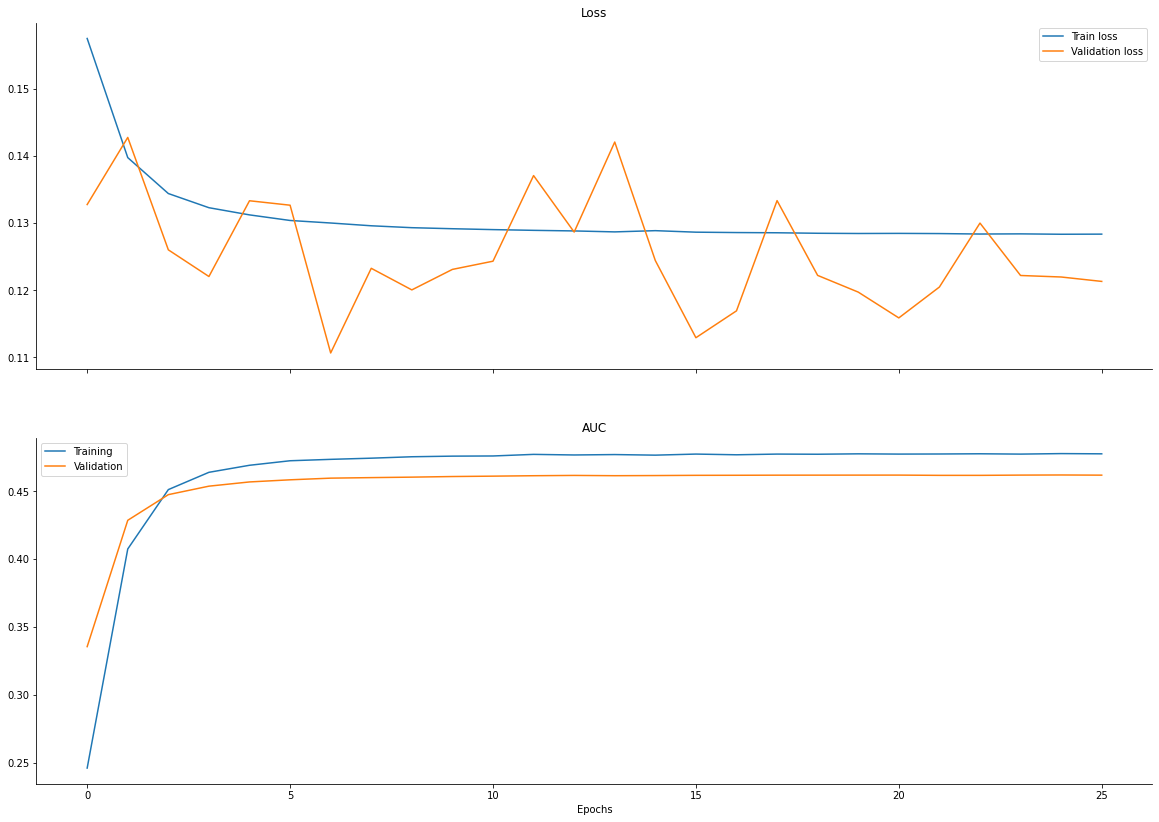

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['auc'], label='Training')
ax2.plot(history['val_auc'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('AUC')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [27]:
model.evaluate(test_ds)

66/66 [==============================] - 6s 74ms/step - loss: 0.1104 - auc: 0.4769


[0.11043694615364075, 0.4769119918346405]

# Results
The final model gives the best result. Hyperparameter tuning could probably help as well as increasing the sequence_length in the TextVectorization.

* baseline logistic regression      : loss: 0.1552 - auc: 0.1489
* LR with class_weight              : loss: 0.6415 - auc: 0.1535
* baseline LSTM                     : loss: 0.1547 - auc: 0.0359
* custom standardization            : loss: 0.1552 - auc: 0.0361
* bidirectional                     : loss: 0.1035 - auc: 0.4643
* lstm units=128                    : loss: 0.1036 - auc: 0.4725
* class_weight                      : loss: 0.4158 - auc: 0.4793
* another lstm layer units=64       : loss: 0.4222 - auc: 0.4588
* sequence length = 500             : loss: 0.4237 - auc: 0.4660
* BinaryFocalCrossentropy           : **loss: 0.1083 - auc: 0.4796**
* lr=1e-4                           : loss: 0.1104 - auc: 0.4769